<a href="https://colab.research.google.com/github/cjpdrury/evidence_networks/blob/fluxes/evidence_network_flux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evidence Network example

In [1]:
# install this version of tf to use decayed lr metric
!pip install tensorflow==2.8.0
!pip install pzflow matplotlib




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 53.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: google-auth-oauthlib
    Found existing insta

In [2]:

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Sep  9 09:26:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
from scipy.stats import norm, multivariate_normal
import sys, os, time, gc

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LeakyReLU, Input,ReLU
from tensorflow.keras import optimizers, callbacks
import h5py

from tensorflow.keras.layers import concatenate, BatchNormalization

import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import requests
import time

from pzflow import Flow
from pzflow.examples import get_twomoons_data

import jax.numpy as jnp


import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['image.cmap'] = 'coolwarm'
plt.rcParams["figure.facecolor"] = "white"
print(tf.config.list_physical_devices('GPU'))
tf.print(tf.constant([0.0]))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[0]
2.8.0


In [4]:
from google.colab import drive
drive.mount('/content/drive')
# !cd /content/drive/MyDrive/ML_Intern/

path = '/content/drive/MyDrive/ML_Intern'



Mounted at /content/drive


## Write flux data to numpy
The data is stored as two HDF5 files, containing SIMBA and TNG simulations. The following cell only needs to be ran once, to store the data as a numpy file.

In [17]:
# for each file in TNG and SIMBA, extract chosen fluxes.
f_TNG = h5py.File(path+'/TNG_master.hdf5', 'r')
f_SIM = h5py.File(path+'/simba_master.hdf5', 'r')


sloan_TNG, sloan_SIM, galex_TNG,galex_SIM = [],[],[],[]

# loop through each folder. Extract all galaxies from chosen filter.
for i in range(len(f_TNG.keys())):
  data = np.array(f_TNG[str(i)]['intrinsic']['SLOAN']['SDSS.g'])
  sloan_TNG.append(data)
  data = np.array(f_TNG[str(i)]['intrinsic']['GALEX']['GALEX.FUV'])
  galex_TNG.append(data)


for i in range(len(f_SIM.keys())):
  data = np.array(f_SIM[str(i)]['intrinsic']['SLOAN']['SDSS.g'])
  sloan_SIM.append(data)
  data = np.array(f_SIM[str(i)]['intrinsic']['GALEX']['GALEX.FUV'])
  galex_SIM.append(data)


flux_TNG = np.stack((np.concatenate(sloan_TNG).ravel(), np.concatenate(galex_TNG).ravel()), axis=1)
flux_SIM = np.stack((np.concatenate(sloan_SIM).ravel(), np.concatenate(galex_SIM).ravel()), axis=1)

np.save(path+'/flux_TNG.npy',flux_TNG)
np.save(path+'/flux_SIMBA.npy',flux_SIM)

In [5]:
# want a TNG and a SIMBA folder each containing all the sloan filters.
f_TNG = h5py.File(path+'/TNG_master.hdf5', 'r')
f_SIM = h5py.File(path+'/simba_master.hdf5', 'r')
filters = list(f_TNG[str(0)]['intrinsic']['SLOAN'].keys())
print(filters)

sloan_TNG, sloan_SIM, flux_TNG = [],[],[]

# for i in range(len(f_TNG.keys())):
# for j, filter in enumerate(filters):
  # if j == 1:
  #   flux_TNG = sloan_TNG
  #   print()


  # if j > 2:
  #   flux_TNG = np.stack((flux_TNG, np.concatenate(sloan_TNG).ravel()), axis=1)


xx = np.zeros((9350,1))
for j, filter in enumerate(filters):
  data = []
  for i in range(5):
      # print(j)
      temp = np.array(f_TNG[str(i)]['intrinsic']['SLOAN'][filter])
      data.extend(temp)

  # xx = np.zeros(len(data))
  # data = np.reshape(data, (len(data),1))
  print(np.shape(xx),np.shape(data))

  if j == 0:
    sloan_TNG = data
  else:
    sloan_TNG  = np.hstack((sloan_TNG, np.reshape(data, (len(data),1)) ))



  # if j > 1:
    # sloan_TNG = = np.hstack((, np.reshape(data, (len(data),1)) ))

  # xx = np.hstack((xx, np.reshape(data, (len(data),1)) ))


['SDSS.g', 'SDSS.i', 'SDSS.r', 'SDSS.u', 'SDSS.z']
(9350, 1) (9350,)
(9350, 1) (9350,)


ValueError: ignored

In [ ]:
xx


array([[0.00000000e+00, 1.00826496e+30, 1.67628141e+30, 1.56165165e+30,
        5.34499408e+29, 1.86869467e+30],
       [0.00000000e+00, 2.23286460e+29, 2.25228548e+29, 3.28863826e+29,
        1.69894525e+29, 2.32851402e+29],
       [0.00000000e+00, 4.37290153e+28, 7.82308513e+28, 6.52967920e+28,
        1.65737131e+28, 8.69658333e+28],
       ...,
       [0.00000000e+00, 3.17197027e+26, 4.15461360e+26, 3.60344617e+26,
        1.67779286e+26, 4.59738809e+26],
       [0.00000000e+00, 1.22984177e+25, 2.01060165e+25, 1.72988129e+25,
        5.09778294e+24, 2.18096304e+25],
       [0.00000000e+00, 3.17560437e+28, 1.84220666e+28, 6.09196014e+28,
        3.64492229e+28, 1.67106495e+28]])

In [ ]:
print(np.shape(sloan_TNG))
print(np.shape(sloan_TNG[1]))

(9350,)
()


In [ ]:
f_TNG[str(i)]['intrinsic']['SLOAN']

<HDF5 group "/4/intrinsic/SLOAN" (5 members)>

In [ ]:
np.shape(sloan_TNG)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(25,)

## Load flux data from numpy file

In [18]:
# unpack data
flux_TNG = np.load(path+'/flux_TNG.npy')
flux_sim = np.load(path+'/flux_SIMBA.npy')
print(np.shape(flux_TNG))

# get headers and convert to pandas
header = 'sloan_g | galex_fuv'
header = header.split('|')

df_TNG = pd.DataFrame(flux_TNG, columns=header)
df_SIM = pd.DataFrame(flux_SIM, columns=header)

# add model labels 'm'
df_TNG['m'] = np.zeros(df_TNG.shape[0])
df_SIM['m'] = np.ones(df_SIM.shape[0])

df_TNG.head()

(2413891, 2)


,sloan_g,galex_fuv,m
0,1.008265e+30,3.683015e+29,0.0
1,2.232865e+29,1.797155e+29,0.0
2,4.372902e+28,1.415112e+27,0.0
3,8.979900e+27,4.046966e+27,0.0
4,4.124089e+28,3.872917e+27,0.0


In [19]:
# assign label of 0 for IllustrisTNG and 1 for SIMBA
flux_TNG = np.append(flux_TNG, np.zeros((len(flux_TNG[:,0]),1)) ,axis=1)
flux_SIM = np.append(flux_SIM, np.ones((len(flux_SIM[:,0]),1)) ,axis=1)

In [20]:
# combine into one dataset
train_flux = np.append(flux_TNG,flux_SIM, axis=0 )

## Produce training, validation and testing data
Note that some galaxies had zero-valued flux. These were removed. The fluxes are scaled to have a mean of zero and standard deviation of 1.

In [21]:
# randomly sample from training data

n_sample = 500000
# n_sample = train_data.shape[0]

choices = np.random.choice(train_flux.shape[0],
                                  size=n_sample,
                                  replace=False)
train_flux = train_flux[choices,:]
print(train_flux.shape)


# separate training, validation and test data
x_train, x_test, y_train, y_test = train_test_split(train_flux[:,:-1], train_flux[:,-1], test_size=0.20, shuffle=True, random_state=44)
x_train, x_val, y_train, y_val = train_test_split(x_train[:,:], y_train[:], test_size=0.20, shuffle=True, random_state=43)

(500000, 3)


In [22]:
print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape,y_test.shape )

(320000, 2) (80000, 2) (100000, 2) (320000,) (80000,) (100000,)


In [23]:
# remove zero valued fluxes.
y_train = y_train[~np.all(x_train == 0, axis=1)]
x_train = x_train[~np.all(x_train == 0, axis=1)]



In [24]:
print(np.mean(x_train[:,0]), np.std(x_train[:,0]), np.max(x_train[:,0]), np.min(x_train[:,0]))

9.900401519375507e+27 1.0210955773243128e+29 3.6372586036599697e+31 1.1946210177347945e+24


(array([4.28332652e-04, 1.60624745e-03, 4.44395127e-03, 1.19130019e-02,
        1.42420607e-02, 1.74545556e-02, 2.64227705e-02, 2.85108922e-02,
        1.96497604e-02, 2.07473628e-02, 2.99029733e-02, 5.04093990e-02,
        4.26190989e-02, 3.28209895e-02, 3.58996304e-02, 4.07451436e-02,
        4.54568027e-02, 4.79197155e-02, 4.83748189e-02, 4.90440887e-02,
        5.12125227e-02, 5.11857520e-02, 5.25778331e-02, 5.01684619e-02,
        5.12660643e-02, 4.76252368e-02, 4.81606526e-02, 4.74646120e-02,
        4.70630502e-02, 4.69291962e-02, 4.71701333e-02, 4.66614883e-02,
        4.74110705e-02, 4.82677358e-02, 5.02487743e-02, 4.95795045e-02,
        5.35951231e-02, 5.57903280e-02, 5.89225105e-02, 6.25365672e-02,
        6.49727092e-02, 7.26291554e-02, 8.03926847e-02, 9.05655852e-02,
        1.10643678e-01, 1.22958242e-01, 1.51281739e-01, 1.77731280e-01,
        2.33253900e-01, 2.37938788e-01, 2.19226006e-01, 2.03591864e-01,
        1.71306290e-01, 1.47533828e-01, 1.64238801e-01, 1.669694

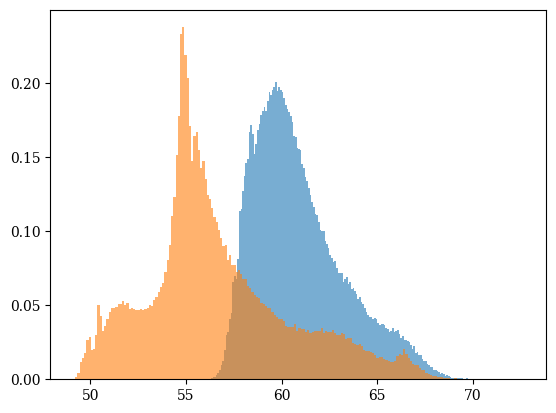

In [25]:
# check distributions
plt.hist(np.log(x_train[:,0]),bins=200, density=True, alpha=0.6)
plt.hist(np.log(x_train[:,1]),bins=200, density=True, alpha=0.6)

In [26]:
x_train[:,:2].shape

(320000, 2)

In [27]:
# normalise each set of data.

x_train_scaled = np.copy(x_train)
x_train_scaled[:,:2] = np.log(x_train_scaled[:,:2])
scaler = StandardScaler()
scaler.fit(x_train_scaled)
x_train_scaled = scaler.transform(x_train_scaled)/20.+0.5

def data_scaler(data):
    """
    Scales input testing and validation data
    """

    data_scaled = np.copy(data)
    data_scaled[:,:2] = np.log(data[:,:2])
    data_scaled = scaler.transform(data_scaled)/20.+0.5

    return data_scaled

x_test_scaled = data_scaler(x_test)
x_val_scaled = data_scaler(x_val)

In [28]:
print(np.mean(x_test_scaled[:,1]), np.std(x_test_scaled[:,1]), np.max(x_test_scaled[:,1]), np.min(x_test_scaled[:,1]))

0.5002229649763025 0.050031835989643704 0.6889791500170453 0.4005466645760643


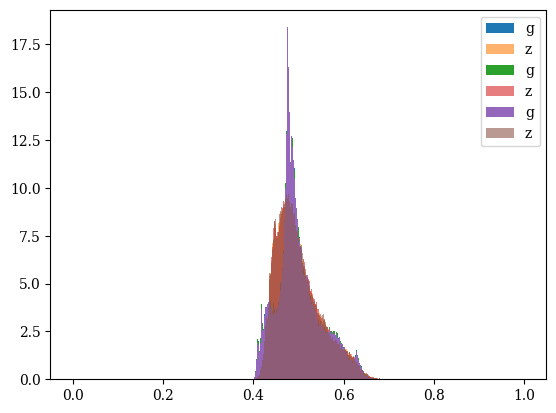

In [29]:
# check distributions match
_ = plt.hist(x_train_scaled[:,1],bins=np.linspace(-0,1,512),density=True, label='g')
_ = plt.hist(x_train_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True, label='z')

_ = plt.hist(x_val_scaled[:,1],bins=np.linspace(-0,1,512),density=True, label='g')
_ = plt.hist(x_val_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True, label='z')

_ = plt.hist(x_test_scaled[:,1],bins=np.linspace(-0,1,512),density=True, label='g')
_ = plt.hist(x_test_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True, label='z')

plt.legend()

In [108]:
# check ratio of models in each dataset
def M_ratio(y):
  scale = np.sum(y)/np.sum(1 - y)
  return scale

print(M_ratio(y_train), M_ratio(y_val), M_ratio(y_test))




1.2958488183553114 1.2916726345641525 1.30462538314397


---------------------------------------------------------

## Define functions for network

In [31]:
def smooth_sign(x, k =100.):

    return 2.*tf.math.sigmoid(k*x) - 1


def parity_odd_power(x, alpha=2):
    return (x)*(tf.math.abs(x)**(alpha-1))


# def leaky_parity_odd_power(x, alpha=2):
#     x_transition = (alpha)**(alpha/(1.-alpha))
#     shift=(alpha)**(1./(1.-alpha)) - x_transition
#     return tf.where(tf.math.abs(x)<x_transition, x, tf.sign(x)*tf.math.abs(x+tf.sign(x)*shift)**alpha)


def leaky_parity_odd_power(x, alpha=2):
    return x + parity_odd_power(x, alpha)

In [88]:
# Evidence Net functions:

class POPExpLoss(tf.keras.losses.Loss):
    """
    Custom exponential loss
    """

    def call(self, model_label, model_pred):
        model_pred =  leaky_parity_odd_power(model_pred, alpha=1)
        model_pred = tf.clip_by_value(model_pred, -50, 50)
        loss_val =  tf.math.exp((0.5 - model_label) * (model_pred) )
        return tf.reduce_mean(loss_val)


class ExpLoss(tf.keras.losses.Loss):
    """
    Custom exponential loss
    """

    def call(self, model_label, model_pred):
        model_pred = tf.clip_by_value(model_pred, -50, 50)
        loss_val =  tf.math.exp((0.5 - model_label) * (model_pred) )
        return tf.reduce_mean(loss_val)


def get_lr_metric(optimizer):
    """
    Learning rate on-the-fly
    :param optimizer:
    :return: learning rate
    """
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)  # I use ._decayed_lr method instead of .lr
        # return optimizer.lr(tf.float32) #C try .lr
    return lr



class DenseNetwork:
    """
    Network that takes in data and returns functions of the Bayesian evidence
    """

    def __init__(self, input_size, weight_init='he_normal', layer_width=100, added_layers=3,
                 learning_rate=1e-4, decay_rate=None, batch_norm_flag=1, residual_flag=0):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.layer_width = layer_width
        self.weight_init = weight_init
        self.decay_rate = decay_rate
        self.added_layers = added_layers
        self.batch_norm_flag = batch_norm_flag
        self.residual_flag = residual_flag


        print('Hyper-parameters:', input_size, weight_init, layer_width, added_layers,
              learning_rate, decay_rate, batch_norm_flag, residual_flag)

    def simple_layer(self, x_in):
        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_in)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        # x_out = tf.tanh(x_out)
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)
        return x_out

    def residual_block(self, x_in):
        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_in)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        # x_out = tf.tanh(x_out)
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)

        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_out)
        x_out = LeakyReLU(alpha=0.1)(x_out) + x_in
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)

        return x_out

    def model(self):

        input_data = (Input(shape=(self.input_size,)))


        x1 = Dense(int(1.1*self.input_size)+20, input_dim=self.input_size, kernel_initializer=self.weight_init)(input_data)
        x_inner = LeakyReLU(alpha=0.1)(x1)
        x_inner = BatchNormalization()(x_inner)
        x_inner = Dense(self.layer_width, input_dim=self.input_size, kernel_initializer=self.weight_init)(x_inner)
        x_inner = LeakyReLU(alpha=0.1)(x_inner)
        x_inner = BatchNormalization()(x_inner)

        # x_inner = tf.tanh(x1)

        for i in range(self.added_layers):
            x_inner = self.residual_block(x_inner)
            # x_inner = self.simple_layer(x_inner)

        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_inner)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        x_out = Dense(1, kernel_initializer=self.weight_init)(x_out)
        x_out = 0.1*x_out + 0.001
        x_out = leaky_parity_odd_power(x_out, alpha=2)

        dense_model = Model(input_data, x_out)

        if self.decay_rate is not None:
            lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=self.learning_rate,
                                                                decay_steps=5000,
                                                                decay_rate=self.decay_rate)
            optimizer = optimizers.Adam(learning_rate=lr_schedule)
            lr_metric = get_lr_metric(optimizer)
            dense_model.compile(optimizer=optimizer,
                                loss=ExpLoss(),
                                metrics=[lr_metric])
        else:
            dense_model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                                loss=ExpLoss())

        return dense_model



class CustomCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Loss: {:.5e}. Val loss: {:.5e}".format(logs['loss'], logs['val_loss']))


# Evidence Net

In [91]:
model_instances, model_instances_model,histories,results = [],[],[],[]
# for i in range(len(expt_value)):

# input size, epochs, number of ensembles
N = x_train_scaled.shape[1]
epochs = 50
n_models = 3
#####
validation_model = np.atleast_2d([y_train, 1. - y_train]).T
#######

with tf.device('/device:GPU:0'):
    for model_count in range(n_models):
        model_instances.append(DenseNetwork(N, weight_init='he_normal',
                                            layer_width=45, added_layers=3,
                                            learning_rate=1e-4, decay_rate=0.9,
                                            batch_norm_flag=1))
        model_instances_model.append(model_instances[-1].model())
        # validation_prediction = (model_instances_model[-1].predict(x_test_scaled))
        # print('Initialization: mean =', validation_prediction.mean(), 'std= ', validation_prediction.std())
        # early stopping
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
        histories.append(model_instances_model[-1].fit(x_train_scaled,y_train,
            epochs=epochs, batch_size=150,
                             shuffle=True,
                             validation_data = (x_val_scaled, y_val),
                             callbacks = [early_stop],
                             verbose=1))
        gc.collect()

Hyper-parameters: 2 he_normal 45 3 0.0001 0.9 1 0
Epoch 1/50
2134/2134 [==============================] - 31s 12ms/step - loss: 0.4001 - lr: 9.7784e-05 - val_loss: 0.3129 - val_lr: 9.5602e-05
Epoch 2/50
2134/2134 [==============================] - 20s 9ms/step - loss: 0.3249 - lr: 9.3484e-05 - val_loss: 0.3127 - val_lr: 9.1399e-05
Epoch 3/50
2134/2134 [==============================] - 21s 10ms/step - loss: 0.3184 - lr: 8.9373e-05 - val_loss: 0.3052 - val_lr: 8.7380e-05
Epoch 4/50
2134/2134 [==============================] - 23s 11ms/step - loss: 0.3139 - lr: 8.5444e-05 - val_loss: 0.3094 - val_lr: 8.3537e-05
Epoch 5/50
2134/2134 [==============================] - 21s 10ms/step - loss: 0.3106 - lr: 8.1686e-05 - val_loss: 0.3070 - val_lr: 7.9864e-05
Epoch 6/50
2134/2134 [==============================] - 21s 10ms/step - loss: 0.3138 - lr: 7.8095e-05 - val_loss: 0.2991 - val_lr: 7.6353e-05
Epoch 7/50
2134/2134 [==============================] - 22s 10ms/step - loss: 0.3054 - lr: 7.4661e-

## Network tuning
Below I have my own set of plots for tuning hyper-parameters. These may become obsolete after using optuna.

In [92]:
# print the final loss and validation losses
losses, val_losses,stopping = [],[],[]
for i in range(len(histories)):
  losses.append( round(histories[i].history['loss'][-1], 4))
  val_losses.append( round(histories[i].history['val_loss'][-1], 4))
  stopping.append(len(histories[i].history['val_loss']))
  # histories[0].history['loss'][-1]

print('parameter values:\n')
print('losses:\n',losses)
print('val_losses:\n',val_losses)
print('early stopping:\n',stopping)

parameter values:

losses:
 [0.295, 0.2956, 0.2945]
val_losses:
 [0.2916, 0.2903, 0.2896]
early stopping:
 [50, 50, 50]


(0.0, 1.0)

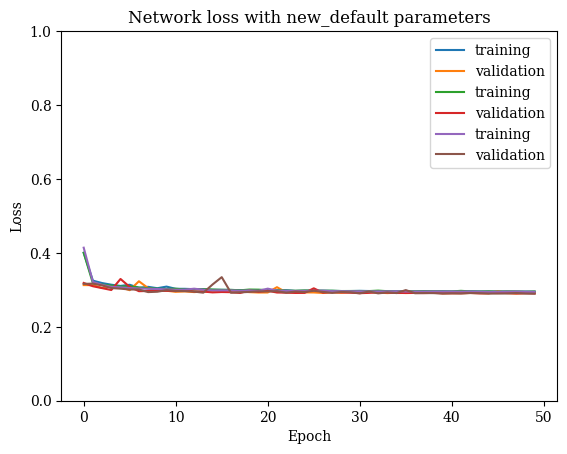

In [93]:
title = 'new_default'

plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.title('Network loss with varying '+title+r' ($\theta$)')
plt.title('Network loss with new_default parameters')
for i in range(len(histories)):
    # if i == 1:
    #     continue

    _ = plt.plot(histories[i].history['loss'][:],label=r'training')#; $\theta$='+str(expt_value[i]))
    _ = plt.plot(histories[i].history['val_loss'][:],label=r'validation')#; $\theta$='+str(expt_value[i]))
    # save the history
    # np.save(path+'/network_tuning/'+title+'_'+str(expt_value[i])+'.npy',histories[0].history)
    # np.save(path+'/network_tuning/'+title+'.npy',histories[0].history)
plt.legend()
plt.ylim(0,1)
# plt.xlim(0,90)
# plt.savefig(path+'/network_tuning/'+title, dpi=250)


Metric data can be loaded from the numpy file as below

In [ ]:
# note the .item() is important
data = np.load(path+'/network_tuning/batch_size_100.npy',allow_pickle=True).item()
data['val_accuracy'][-1]

0.7307199835777283

## Network Output
The network estimates log K values for the test data. As the ratio of priors is not 1, the network predictions should be transformed to give logK.

In [94]:
# collect network outputs f(xO).
validation_prediction = (model_instances_model[0].predict(x_test_scaled))
for i in range(n_models-1):
  print(i)
  temp = (model_instances_model[i+1].predict(x_test_scaled))
  validation_prediction = np.append(validation_prediction, temp, axis=1)


# network output f(xO).
# validation_prediction = (model_instances_model[-1].predict(x_test_scaled))

# if using l-POP:
# validation_prediction = leaky_parity_odd_power(validation_prediction)
# validation_prediction = validation_prediction.numpy()

# print(validation_prediction.shape)

0
1


In [95]:
# calucalte mean average output
validation_prediction_avg = np.mean(validation_prediction, axis=1)
print(validation_prediction)
print(validation_prediction_avg)

[[-5.357578   -5.3570185  -5.490716  ]
 [-0.17251334 -0.09134772 -0.10863484]
 [-3.6232817  -3.9098287  -3.774723  ]
 ...
 [28.558949   16.412802   21.547941  ]
 [30.324749   27.339191   31.373016  ]
 [-5.8312416  -6.053277   -6.3124    ]]
[-5.40177   -0.1241653 -3.7692778 ... 22.173231  29.678986  -6.0656395]


In [ ]:
# plt.hist(validation_prediction,bins=200)
# plt.plot(validation_prediction,'.')
# plt.ylim(-100,100)


# validation_prediction_mean = np.mean(validation_prediction)
# log_K_net = np.log10(np.exp(validation_prediction_mean))
# print(log_K)




# Coverage tests
Here I've tried to recreate the coverage tests using my own code. First we calculate p(M1|x). We then bin the posterior probabilities and examine the fraction of model 1 labels (SIMBA) in each bin.

In [96]:
# calculate posteriors from network log K values
posterior_model_prob = np.exp(validation_prediction_avg)/(1+np.exp(validation_prediction_avg)) # p(M1|x)
print(posterior_model_prob.shape)

# prepare posterior bins
nbins = 100
probability_array  = np.linspace(0,1,nbins)


(100000,)


In [97]:
def coverage_test(post_model_prob, prob_array):
  '''
  Performs the coverage tests to evaluate calibration of the network
  :param post_model_prob: array of p(M1|x) predicted by network
  :param prob_array: array of chosen bins for posteriors
  :returns: posterior bin centres, validation fractions, post_bin_n (number of data prob in each bin),
            binomial_std (standard error of binomial)
  '''

  # perform coverage test
  bin_centres, fractions, post_bin_n = [],[],[]

  for i in range(0,len(prob_array)-1):
    # bin posteriors
    indexes = np.where((post_model_prob > prob_array[i])
                                        & (post_model_prob < prob_array[i+1]))[0]
    post_bin = post_model_prob[indexes]
    post_bin_mid = np.float32((prob_array[i]+prob_array[i+1]) / 2)
    post_bin_size = np.float32(len(post_bin))

    # get fraction of model 1 labels in each bin
    label_bin = y_test[indexes]
    fraction = np.sum(label_bin) / len(label_bin)

    bin_centres.append(post_bin_mid), fractions.append(fraction), post_bin_n.append(post_bin_size)


  # get the binomial error for each bin
  binomial_std = np.sqrt((np.asarray(bin_centres)*(1.-np.asarray(bin_centres))) / np.asarray(post_bin_n))

  return bin_centres, fractions, post_bin_n, binomial_std

In [98]:
bin_centres, fractions, post_bin_n, binomial_std = coverage_test(posterior_model_prob, probability_array)

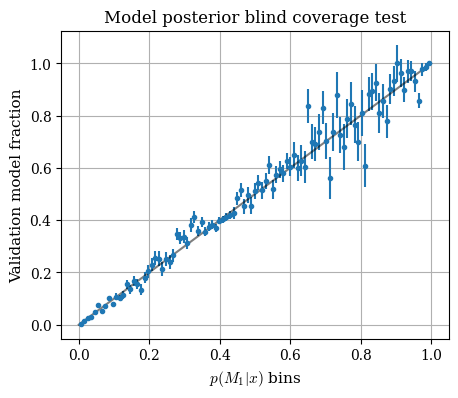

In [99]:
plt.figure(figsize=(5,4))

# plt.plot(bin_centres, fractions,'.')
# plt.plot(post_bin_means, fractions,'.')
plt.errorbar(bin_centres, fractions, np.asarray(binomial_std), marker='.', ls='')
plt.title('Model posterior blind coverage test')
plt.xlabel(r'$p(M_1 | x)$ bins', fontsize=11)
plt.ylabel(str('Validation model fraction'), fontsize=11)
plt.plot([0,1],[0,1],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.savefig(path+'coverage_test_20_B.png', dpi=250)
# plt.axis('equal')

## Residual between model fraction and posterior probability from evidence network

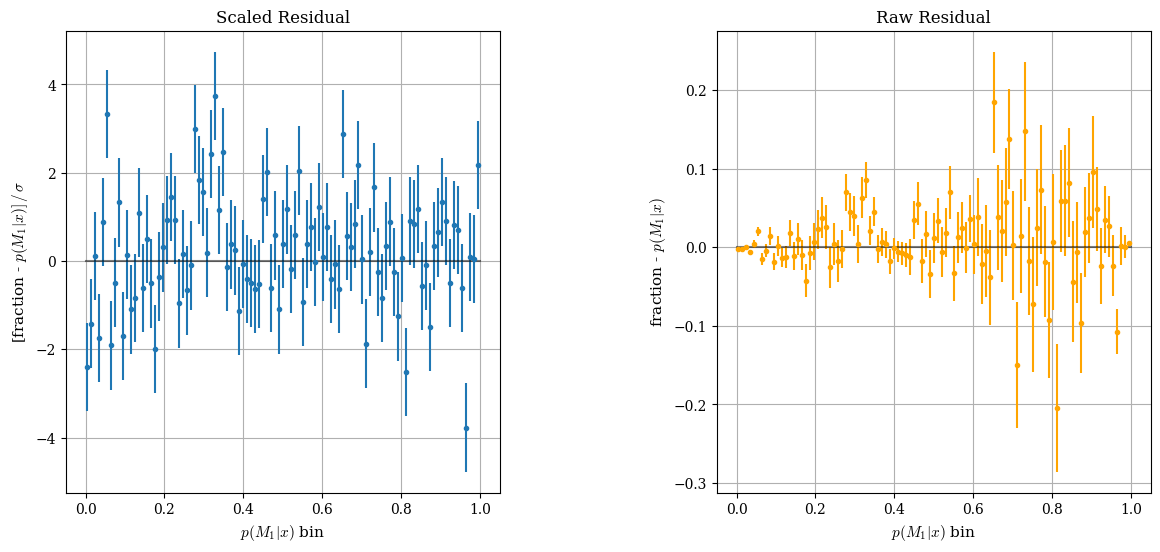

In [100]:
residual = (np.asarray(fractions) - np.asarray(bin_centres))
scaled_residual = residual/np.asarray(binomial_std)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
# plt.plot(post_bin_means, residual, marker='.', ls='')
plt.errorbar(bin_centres, scaled_residual,yerr=binomial_std/np.asarray(binomial_std), marker='.', ls='')
# plt.plot(post_bin_means, residual*binomial_std, marker='.', ls='',c='orange')
plt.title('Scaled Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'[fraction - $p(M_1 | x) ] \, / \, \sigma$', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)
# plt.ylim(-4,4)

plt.subplot(1,2,2)
# plt.plot(post_bin_means, residual, marker='.', ls='')
plt.errorbar(bin_centres, residual,yerr=binomial_std, marker='.', ls='',c='orange')
plt.title('Raw Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'fraction - $p(M_1 | x)  $', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.subplots_adjust(wspace=.5)

# plt.savefig(path+'/residuals_unobservables_EvidenceNet.png', dpi=250)


In [102]:
print(np.mean(scaled_residual))
print(np.std(scaled_residual))

0.21590541120644172
1.2810551951920492


## Normalising flows
The following cells use the package PZ Flow to learn the probability density function of the data. We train the neural density estimator to estimate p(x|M1) and p(x|M0), then derive the Bayes factor from this.

In [103]:
# turn datasets into pandas dataframe for PZ Flow.
train_df = pd.DataFrame({'stellar_mass': x_train_scaled[:,0], 'stellar_metallicity': x_train_scaled[:,1], 'model': y_train})
val_df = pd.DataFrame({'stellar_mass': x_val_scaled[:,0], 'stellar_metallicity': x_val_scaled[:,1], 'model': y_val})
test_df = pd.DataFrame({'stellar_mass': x_test_scaled[:,0], 'stellar_metallicity': x_test_scaled[:,1], 'model': y_test})

# separate training and validation by model.
train_M1_df = train_df[train_df['model'] == 1]
train_M0_df = train_df[train_df['model'] == 0]
val_M1_df = val_df[val_df['model'] == 1]
val_M0_df = val_df[val_df['model'] == 0]




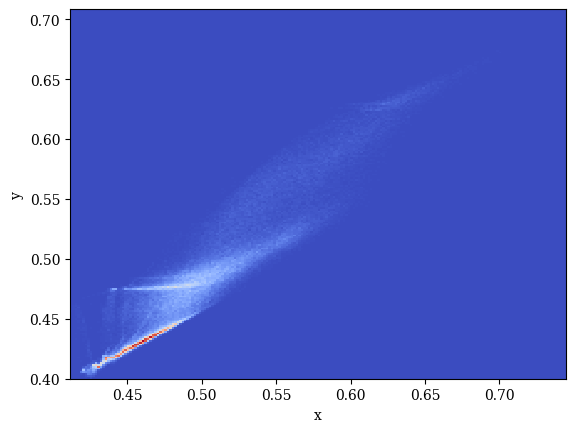

In [104]:
# plt.hist2d(val_M1_df.iloc[:,0],val_M1_df.iloc[:,1] , bins=200)
plt.hist2d(train_M1_df.iloc[:,0],train_M1_df.iloc[:,1] , bins=200)
plt.xlabel("x")
plt.ylabel("y")
# plt.xlim(0.4, 0.6)
# plt.ylim(0.4, 0.6)
plt.show()


In [105]:
# train the normalising flow.
flow_M1 = Flow(["stellar_mass", 'stellar_metallicity'])

train_loss_M1, val_loss_M1 = flow_M1.train(train_M1_df, val_M1_df, verbose=True, epochs=50, batch_size=100, progress_bar=True)


Training 50 epochs 
Loss:
(0) -1.7143  -1.7152


  0%|          | 0/50 [00:00<?, ?it/s]

(1) -4.7030  -4.6961


  6%|▌         | 3/50 [00:39<08:44, 11.15s/it]

(3) -4.7357  -4.7299


 10%|█         | 5/50 [00:50<05:44,  7.65s/it]

(5) -4.7293  -4.7245


 14%|█▍        | 7/50 [00:59<04:18,  6.00s/it]

(7) -4.7421  -4.7353


 18%|█▊        | 9/50 [01:17<04:57,  7.25s/it]

(9) -4.7366  -4.7288


 22%|██▏       | 11/50 [01:31<04:41,  7.22s/it]

(11) -4.7316  -4.7250


 26%|██▌       | 13/50 [01:43<04:01,  6.54s/it]

(13) -4.7486  -4.7422


 30%|███       | 15/50 [01:53<03:14,  5.56s/it]

(15) -4.7365  -4.7293


 34%|███▍      | 17/50 [02:03<02:55,  5.31s/it]

(17) -4.7447  -4.7385


 38%|███▊      | 19/50 [02:15<02:55,  5.67s/it]

(19) -4.7261  -4.7186


 42%|████▏     | 21/50 [02:24<02:27,  5.07s/it]

(21) -4.7365  -4.7309


 46%|████▌     | 23/50 [02:35<02:22,  5.26s/it]

(23) -4.7575  7546569135286428132404304208199680.0000


 50%|█████     | 25/50 [02:44<02:05,  5.03s/it]

(25) -4.7469  -4.7412


 54%|█████▍    | 27/50 [02:55<01:55,  5.03s/it]

(27) -4.7557  -4.7487


 58%|█████▊    | 29/50 [03:05<01:50,  5.25s/it]

(29) -4.7507  -4.7443


 62%|██████▏   | 31/50 [03:15<01:34,  4.96s/it]

(31) -4.7493  -4.7425


 66%|██████▌   | 33/50 [03:26<01:28,  5.21s/it]

(33) -4.7541  -4.7478


 70%|███████   | 35/50 [03:35<01:14,  4.97s/it]

(35) -4.7571  -4.7500


 74%|███████▍  | 37/50 [03:48<01:14,  5.75s/it]

(37) -4.7356  -4.7289


 78%|███████▊  | 39/50 [03:59<01:02,  5.73s/it]

(39) -4.7572  -4.7513


 82%|████████▏ | 41/50 [04:17<01:07,  7.52s/it]

(41) -4.7538  -4.7483


 86%|████████▌ | 43/50 [04:26<00:42,  6.01s/it]

(43) -4.7646  -4.7573


 90%|█████████ | 45/50 [04:37<00:28,  5.74s/it]

(45) -4.7472  -4.7396


 94%|█████████▍| 47/50 [04:46<00:15,  5.24s/it]

(47) -4.7205  -4.7154


 98%|█████████▊| 49/50 [04:57<00:05,  5.15s/it]

(49) -4.7646  -4.7583


100%|██████████| 50/50 [05:01<00:00,  6.03s/it]

(50) -4.7410  -4.7335


In [106]:
flow_M0 = Flow(["stellar_mass", 'stellar_metallicity'])

train_loss_M0, val_loss_M0 = flow_M0.train(train_M0_df, val_M0_df, verbose=True, epochs=50, batch_size=100, progress_bar=True)

Training 50 epochs 
Loss:
(0) -2.0442  -2.0437


  2%|▏         | 1/50 [00:23<19:26, 23.81s/it]

(1) -5.6804  -5.6770


  6%|▌         | 3/50 [00:36<08:07, 10.37s/it]

(3) -5.7363  -5.7325


 10%|█         | 5/50 [00:43<04:41,  6.26s/it]

(5) -5.7138  -5.7113


 14%|█▍        | 7/50 [00:52<03:46,  5.28s/it]

(7) -5.7537  -5.7482


 18%|█▊        | 9/50 [00:59<02:57,  4.33s/it]

(9) -5.7756  -5.7712


 22%|██▏       | 11/50 [01:08<02:46,  4.27s/it]

(11) -5.7737  -5.7692


 26%|██▌       | 13/50 [01:15<02:27,  3.98s/it]

(13) -5.7686  -5.7646


 30%|███       | 15/50 [01:23<02:19,  3.99s/it]

(15) -5.7585  -5.7542


 34%|███▍      | 17/50 [01:31<02:09,  3.93s/it]

(17) -5.7748  -5.7704


 38%|███▊      | 19/50 [01:38<01:59,  3.87s/it]

(19) -5.7836  -5.7778


 42%|████▏     | 21/50 [01:50<02:19,  4.80s/it]

(21) -5.7852  -5.7792


 46%|████▌     | 23/50 [01:56<01:49,  4.07s/it]

(23) -5.7427  -5.7376


 50%|█████     | 25/50 [02:05<01:47,  4.31s/it]

(25) -5.6958  -5.6919


 54%|█████▍    | 27/50 [02:13<01:34,  4.11s/it]

(27) -5.8002  -5.7946


 58%|█████▊    | 29/50 [02:22<01:30,  4.29s/it]

(29) -5.7591  -5.7536


 62%|██████▏   | 31/50 [02:29<01:13,  3.89s/it]

(31) -5.7978  -5.7923


 66%|██████▌   | 33/50 [02:37<01:09,  4.08s/it]

(33) -5.8023  -5.7972


 70%|███████   | 35/50 [02:53<01:30,  6.05s/it]

(35) -5.7777  -5.7724


 74%|███████▍  | 37/50 [03:02<01:06,  5.10s/it]

(37) -5.8046  -5.7988


 78%|███████▊  | 39/50 [03:09<00:49,  4.48s/it]

(39) -5.8046  -5.8000


 82%|████████▏ | 41/50 [03:18<00:37,  4.22s/it]

(41) -5.7542  -5.7489


 86%|████████▌ | 43/50 [03:25<00:27,  3.89s/it]

(43) -5.7444  -5.7391


 90%|█████████ | 45/50 [03:33<00:20,  4.06s/it]

(45) -5.8052  -5.7992


 94%|█████████▍| 47/50 [03:40<00:11,  3.73s/it]

(47) -5.8024  -5.7967


 98%|█████████▊| 49/50 [03:49<00:04,  4.06s/it]

(49) -5.8100  -5.8045


100%|██████████| 50/50 [03:52<00:00,  4.66s/it]

(50) -5.7915  -5.7868


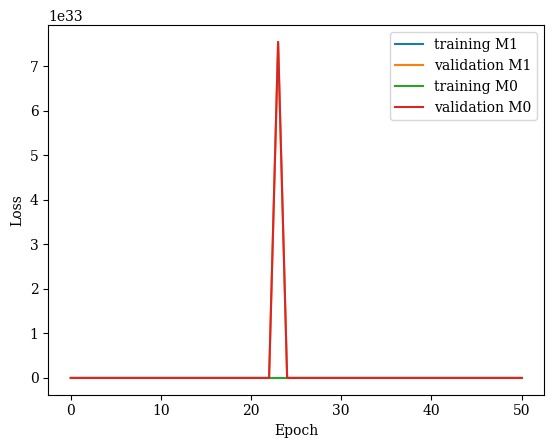

In [107]:
plt.plot(train_loss_M1, label='training M1')
plt.plot(val_loss_M1, label='validation M1')
plt.plot(train_loss_M1, label='training M0')
plt.plot(val_loss_M1, label='validation M0')
# plt.ylim(-5,-4)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Flow Output

In [109]:
def density(flow, xlim=(0.4,0.7), ylim=(0.4,0.7) ):
  '''
  Calculates a grid of density values
  '''

  nx, ny = (1000, 1000)
  x, y = np.linspace(xlim[0], xlim[1], nx), np.linspace(ylim[0], ylim[1], ny)
  # y = np.linspace(ylim[0], ylim[1], ny)
  xv, yv = np.meshgrid(x, y)
  X, Y = xv.flatten(), yv.flatten()
  # Y = yv.flatten()
  grid_df = pd.DataFrame({'stellar_mass': X, 'stellar_metallicity': Y})
  density = np.exp(flow.log_prob(grid_df))
  density = density.reshape((nx,ny))
  # matrix needs flipping.
  density = np.flipud(density)

  return density





In [110]:
# define grid limits for densities.
xx, yy = (0.4,0.65), (0.4,0.65)
dens_M1 = density(flow_M1, xx,yy)
dens_M0 = density(flow_M0, xx,yy)

[Text(0.5, 0, 'stellar mass (scaled)'),
 Text(0, 0.5, 'stellar metallicity (scaled)'),
 Text(0.5, 0, 'stellar mass (scaled)'),
 Text(0, 0.5, 'stellar metallicity (scaled)'),
 Text(0.5, 0, 'stellar mass (scaled)'),
 Text(0, 0.5, 'stellar metallicity (scaled)'),
 Text(0.5, 0, 'stellar mass (scaled)'),
 Text(0, 0.5, 'stellar metallicity (scaled)')]

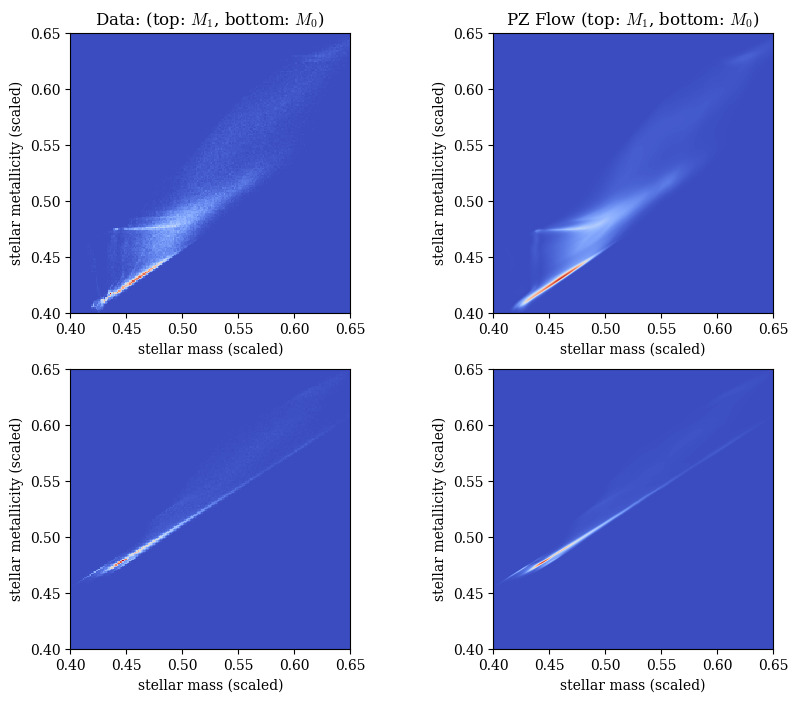

In [111]:
# plot outputs.
fig, ax = plt.subplots(2,2,  figsize=(10,8))

ax[0,0].set_title('Data: (top: $M_1$, bottom: $M_0$)')
ax[0,0].hist2d(train_M1_df.iloc[:,0],train_M1_df.iloc[:,1], bins=[np.linspace(xx[0],xx[1],200), np.linspace(yy[0],yy[1],200)])
ax[1,0].hist2d(train_M0_df.iloc[:,0],train_M0_df.iloc[:,1], bins=[np.linspace(xx[0],xx[1],200), np.linspace(yy[0],yy[1],200)])
ax[0,0].axis('square')
ax[1,0].axis('square')


ax[0,1].set_title('PZ Flow (top: $M_1$, bottom: $M_0$)')
ax[0,1].imshow(dens_M1,extent=[xx[0],xx[1],yy[0],yy[1]])
ax[1,1].imshow(dens_M0,extent=[xx[0],xx[1],yy[0],yy[1]])


plt.setp(ax, xlabel='stellar mass (scaled)' , ylabel='stellar metallicity (scaled)')



---



---



In [ ]:
logprob_M1 = flow_M1.log_prob(test_df)
logprob_M0 = flow_M0.log_prob(test_df)

idx = np.where(logprob_M1 > -1e10)
logprob_M1 = logprob_M1[idx]
logprob_M0 = logprob_M0[idx]
# plt.hist(grid_M1, bins=100, alpha=0.6)
# plt.hist(grid_M0, bins=100, alpha=0.6)

The flow outputs log( p(x|M1) ) and log( p(x|M0) ). We combine these to get log K.

In [ ]:
# include priors ratio correction to compare output of EvidenceNet and PZFlow.
logK_flow = logprob_M1 -  logprob_M0 + np.log(M_ratio(y_test))

Calculate the Bayes factors and perform a coverage test.

0.27632126 1.8542194


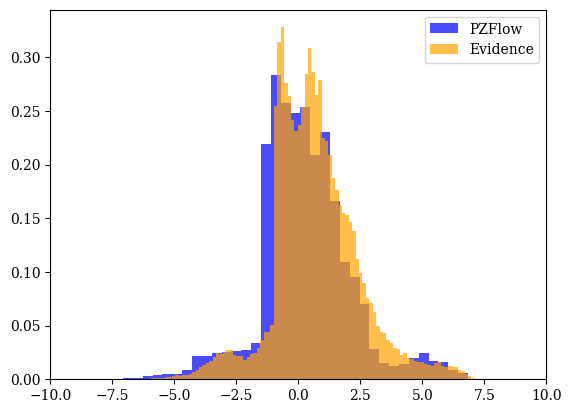

In [ ]:
print(np.mean(logK_flow), np.std(logK_flow))
plt.hist(logK_flow,bins=100,density=True, alpha=0.7,color='blue', label='PZFlow')
plt.hist(validation_prediction,bins=100,density=True, alpha=0.7, color='orange', label='Evidence')
plt.xlim(-10,10)
plt.legend()

In [ ]:
# get p(M1|x) from logK
post_flow = np.exp(logK_flow)/(1+np.exp(logK_flow))

# prepare posterior bins
nbins = 100
probability_array  = np.linspace(0,1,nbins)
# print(probability_array )

In [ ]:
bin_centres_flow, fractions_flow, post_bin_n_flow, binomial_std_flow = coverage_test(post_flow, probability_array)

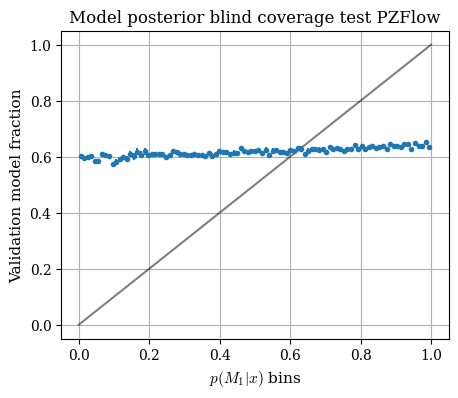

In [ ]:
plt.figure(figsize=(5,4))

plt.errorbar(bin_centres_flow, fractions_flow, np.asarray(binomial_std_flow), marker='.', ls='')
plt.title('Model posterior blind coverage test PZFlow')
plt.xlabel(r'$p(M_1 | x)$ bins', fontsize=11)
plt.ylabel(str('Validation model fraction'), fontsize=11)
plt.plot([0,1],[0,1],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

# plt.savefig(path+'coverage_test_20_B.png', dpi=250)
# plt.axis('equal')

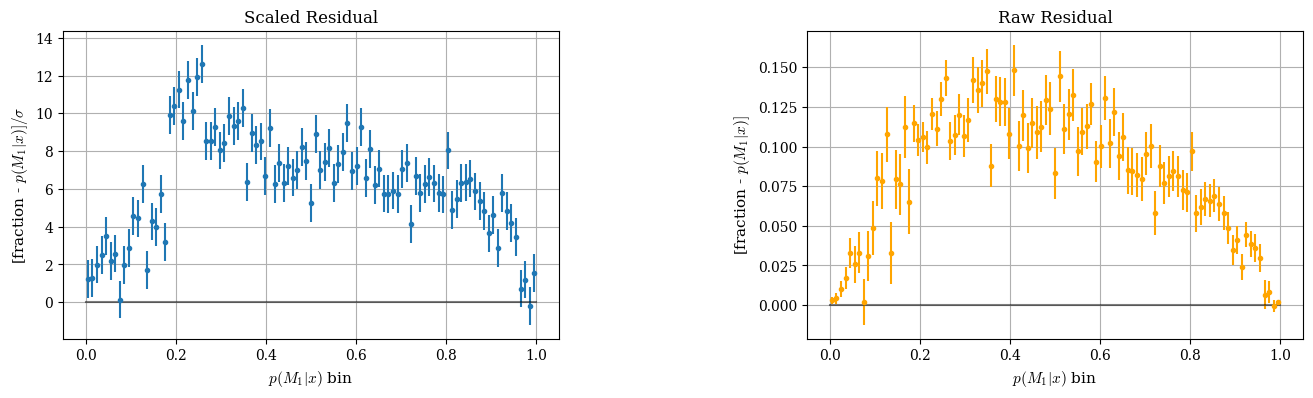

In [ ]:
residual_flow = (np.asarray(fractions_flow) - np.asarray(bin_centres_flow))
scaled_residual_flow = residual_flow/np.asarray(binomial_std_flow)

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.errorbar(bin_centres_flow, scaled_residual_flow,yerr=binomial_std_flow/np.asarray(binomial_std_flow), marker='.', ls='')
plt.title('Scaled Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'[fraction - $p(M_1 | x) ] / \sigma$', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.subplot(1,2,2)
plt.errorbar(bin_centres_flow, residual_flow,yerr=binomial_std_flow, marker='.', ls='',c='orange')
plt.title('Raw Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'[fraction - $p(M_1 | x) ] $', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.subplots_adjust(wspace=.5)


In [ ]:
print(np.mean(scaled_residual_flow))
print(np.std(scaled_residual_flow))

6.250387557425225
2.74017073373878
